In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [2]:
train = pd.read_csv("train_V2.csv") #train_V2 is the dataset in which the missing values are removed.
train = train.drop(["Unnamed: 0", "Tax_assess_Year"], axis = 1) #Tax_assess_Year is all 2015. No sense to keep it.

#Somehow a few variables change back to numeric after reading csv using pandas. 
toobject = ["FIPS", "County", "Raw_census", "Zipcode", "Land_Type"]
for col in toobject:
    train[col] = train[col].astype("object")

#convert tran_date to month and day   
train["tran_month"] = [datetime.strptime(x, "%Y-%m-%d").month for x in train.tran_date]
train["tran_day"] = [datetime.strptime(x, "%Y-%m-%d").day for x in train.tran_date]
train = train.drop("tran_date", axis = 1)

#set index
train.set_index("Parcel_ID", drop = True, inplace = True)

#train.to_csv("train_V3.csv")

In [3]:
train.head()

,logerror,AC_Type,Arch_Type,Basement_Area,Bath_Count,Bed_Count,Frame_Type,Quality_Level,Bed_with_bath_Count,Deck_Type,...,Tax_Amount,Tax_delinq_YN,Tax_delinq_Year,Census,Unit_Count_KU,Quality_Level_KU,Story_Count_KU,Lot_Area_KU,tran_month,tran_day
Parcel_ID,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1.0,Unknown,0.0,2.0,3.0,Unknown,4.0,2.0,Unknown,...,6735.88,N,-10000.0,60371066461000.0,1,1,0,1,1,1
14366692,-0.1684,Unknown,Unknown,0.0,3.5,4.0,Unknown,-1.0,3.5,Unknown,...,10153.02,N,-10000.0,Unknown,0,0,0,1,1,1
12098116,-0.0040,1.0,Unknown,0.0,3.0,2.0,Unknown,4.0,3.0,Unknown,...,11484.48,N,-10000.0,60374638003000.0,1,1,0,1,1,1
12643413,0.0218,1.0,Unknown,0.0,2.0,2.0,Unknown,4.0,2.0,Unknown,...,3048.74,N,-10000.0,60372963002000.0,1,1,0,1,1,2
14432541,-0.0050,Unknown,Unknown,0.0,2.5,4.0,Unknown,-1.0,2.5,Unknown,...,5488.96,N,-10000.0,60590423381000.0,0,0,1,1,1,2


## Merge the train data with the geographical clusters we got from Kmeans.

In [4]:
geo = pd.read_csv("train_geo.csv")

geo.set_index("Parcel_ID", drop = True, inplace = True)

geo.head()

,FIPS,Latitude,Longitude,Raw_census,City,County,Neighborhood,Zipcode,cluster
Parcel_ID,,,,,,,,,
11016594,6037.0,34280990.0,-118488536.0,6.037107e+07,12447.0,3101.0,31817.0,96370,2
14366692,6059.0,33668120.0,-117677556.0,6.059052e+07,32380.0,1286.0,Unknown,96962,3
12098116,6037.0,34136312.0,-118175032.0,6.037464e+07,47019.0,3101.0,275411.0,96293,5
12643413,6037.0,33755800.0,-118309000.0,6.037296e+07,12447.0,3101.0,54300.0,96222,7
14432541,6059.0,33485643.0,-117700234.0,6.059042e+07,17686.0,1286.0,Unknown,96961,3


In [5]:
#delete the geographical info from train
train = train.drop(["FIPS","Latitude","Longitude","Raw_census","City","County","Neighborhood","Zipcode","Census", "Zone_desc","Land_Code"], axis = 1)

In [6]:
#merge train and geographical cluster together.
train = train.merge(pd.DataFrame(geo["cluster"]), left_index = True, right_index = True)

In [7]:
toobject = ["Land_Type","cluster"]
for col in toobject:
    train[col] = train[col].astype("object")

In [62]:
#train.to_csv("traingeo_merge.csv")

In [ ]:
#train = pd.read_csv("traingeo_merge.csv")

## Response variable

In [8]:
y = train.logerror

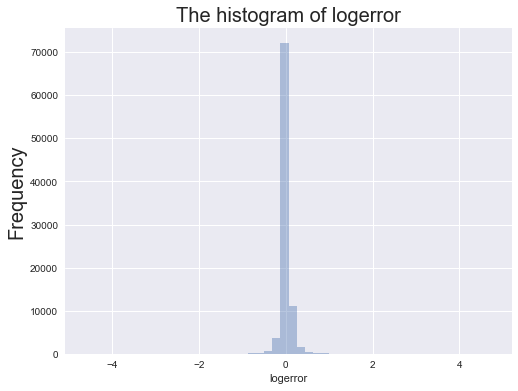

In [9]:
plt.figure(figsize=(8, 6))
ax = sns.distplot(y, kde = False)
ax.set_title("The histogram of logerror",fontsize = 20)
ax.set_ylabel("Frequency",fontsize = 20)

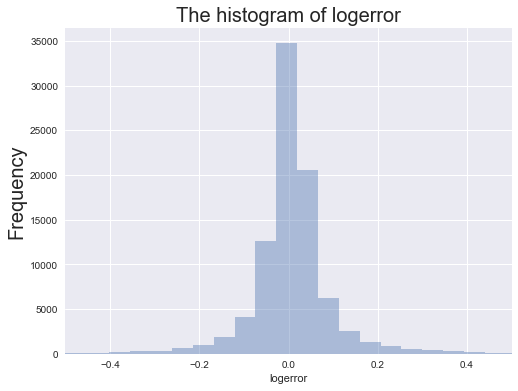

In [10]:
plt.figure(figsize=(8, 6))
ax = sns.distplot(y, kde = False, bins = 200)
ax.set(xlim = (-0.5, 0.5))
ax.set_title("The histogram of logerror",fontsize = 20)
ax.set_ylabel("Frequency",fontsize = 20)

### The distribution of logerror is near to normal distribution. No need to transform the response variable.

## Correlation between variables

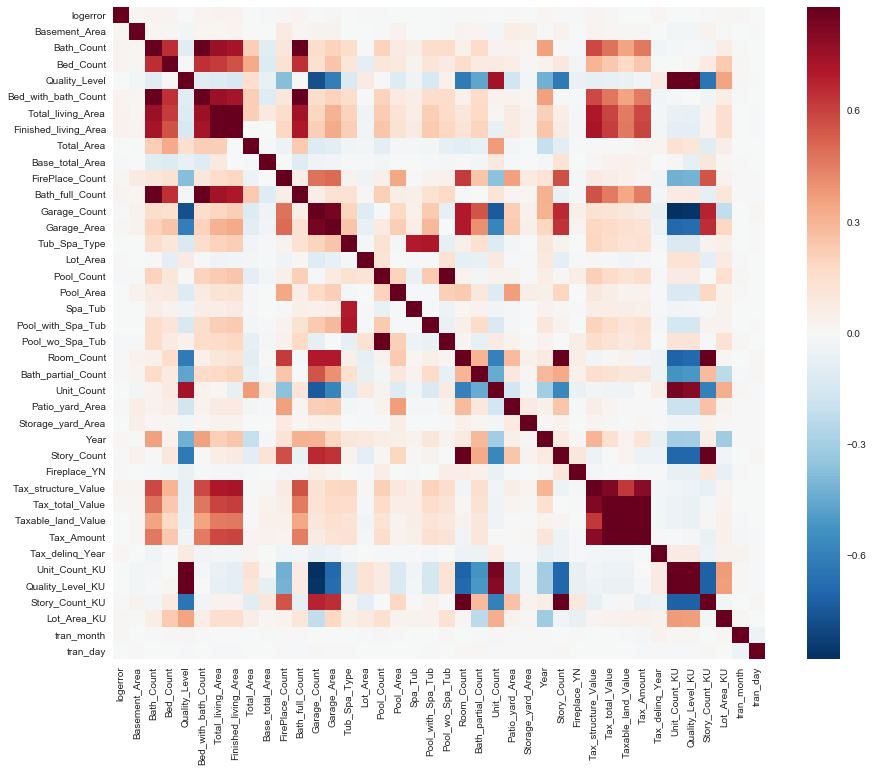

In [12]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

### logerror seems only have weak correlation with several numerical variables. Along the diagonal, we can observe several blocks with closely correlated variables, such as Bath_Count and Bed_Count, Bed_with_bath_Count, Total_living_Area and Finished_living_Area, etc. 

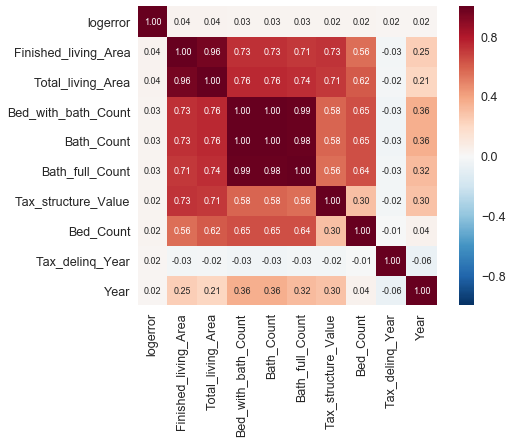

In [13]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'logerror')['logerror'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, annot_kws={'size': 9},square=True, fmt='.2f', 
                 yticklabels=cols.values, xticklabels=cols.values)

In [10]:
import pandas as pd
from collections import Counter
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble import AdaBoostRegressor as Adr
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder 

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, lars_path
from sklearn.svm import LinearSVR, SVR
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
train = pd.read_csv("traingeo_merge.csv", index_col = 0)

toobject = ["Land_Type","cluster"]
for col in toobject:
    train[col] = train[col].astype("object")
    
y = train.logerror

X = train.drop("logerror", axis = 1)

X = pd.get_dummies(X)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Linear Regression

In [21]:
Lin_regr = LinearRegression(normalize = True)
Lin_regr.fit(Xtr, ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [20]:
Lin_regr.score(Xtr, ytr)

0.0076513331570207122

In [25]:
mse = np.mean((Lin_regr.predict(Xte) - yte)**2)
print "The MSE of Linear Regression is " + str(mse)

The MSE of Linear Regression is 7.08697486847e+21


## Lasso Regression

Computing regularization path using the coordinate descent lasso...
alpha chosen by cross-validation is 8.31179725182e-07


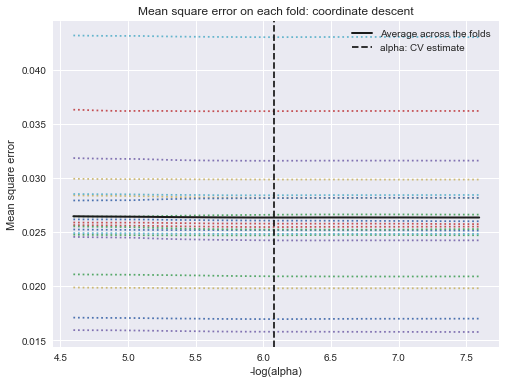

In [44]:
print("Computing regularization path using the coordinate descent lasso...")
Lasso_cv = LassoCV(cv = 20, max_iter = 2000, normalize = True).fit(Xtr, ytr)

# Display results
m_log_alphas = -np.log10(Lasso_cv.alphas_)

plt.figure(figsize=(8, 6))
plt.plot(m_log_alphas, Lasso_cv.mse_path_, ':')
plt.plot(m_log_alphas, Lasso_cv.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(Lasso_cv.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent')
plt.axis('tight')

print "alpha chosen by cross-validation is " + str(Lasso_cv.alpha_)

In [45]:
las_regr = Lasso(alpha = Lasso_cv.alpha_, normalize = True)
las_regr.fit(Xtr, ytr)

mse = np.mean((las_regr.predict(Xte) - yte)**2)
print "The MSE of Linear Regression is " + str(mse)

The MSE of Linear Regression is 0.0240007795803


## Ridge Regression

alpha chosen by cross-validation is 0.01


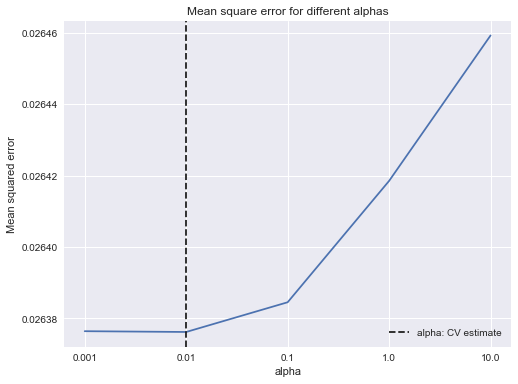

In [93]:
Ridge_cv = RidgeCV(alphas = (0.001, 0.01, 0.1, 1.0, 10.0), normalize = True, store_cv_values = True).fit(Xtr, ytr)
print "alpha chosen by cross-validation is " + str(Ridge_cv.alpha_)

plt.figure(figsize=(8, 6))
plt.plot(range(len(alphas_)), Ridge_cv.cv_values_.mean(axis = 0))
plt.xticks(range(5), ('0.001', '0.01', '0.1', '1.0', '10.0'))
plt.title('Mean square error for different alphas')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.axvline(1, linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()

In [94]:
ridge_regr = Ridge(alpha = Ridge_cv.alpha_, normalize = True).fit(Xtr, ytr)

mse = np.mean((ridge_regr.predict(Xte) - yte)**2)
print "The MSE of Linear Regression is " + str(mse)

The MSE of Linear Regression is 0.0239840000665


## Linear SVM Regression

In [12]:
Lin_SVR  = LinearSVR(loss = 'squared_epsilon_insensitive', dual = False)
grid = GridSearchCV(Lin_SVR,param_grid = dict(C = np.logspace(-2,3,6)), cv = KFold(n_splits = 5, random_state = 5), n_jobs = 55)
grid.fit(Xtr,ytr)

After running on the server, the best parameter is C = 1000

In [14]:
Lin_SVR  = LinearSVR(C = 1000, loss = 'squared_epsilon_insensitive', dual = False).fit(Xtr, ytr)
mse = np.mean((Lin_SVR.predict(Xte) - yte)**2)
print "The MSE of Linear SVM Regression is " + str(mse)

The MSE of Linear SVM Regression is 0.0240299833173


## Random forest

In [ ]:
## tune the random forest parameters. Runned in server
t0 = time.time()
rfr_model = RFR()
cross_validation = StratifiedKFold(n_splits = 5, shuffle = False, random_state = None)
parameter_grid = {"n_estimators":np.arange(10, 100, 10), "max_depth": range(5,10)}
grid_search = GridSearchCV(rfr_model, param_grid=parameter_grid, cv=cross_validation, n_jobs=4)
grid_search.fit(Xtr, ytr)
print grid_search.best_score_
print grid_search.best_params_
print "The time used", time.time() - t0


#-0.0134198274734
#{'n_estimators': 90, 'max_depth': 5}
#The time used 1455.31491184

{'n_estimators': 90, 'max_depth': 5}

In [16]:
rfr = RFR(n_estimators = 90, max_depth = 5)
rfr.fit(Xtr, ytr)
rfrpred = rfr.predict(Xte)
mserfr = np.mean((yte - rfrpred)**2)
mserfr
#0.024127893096301516

0.02416135186839929

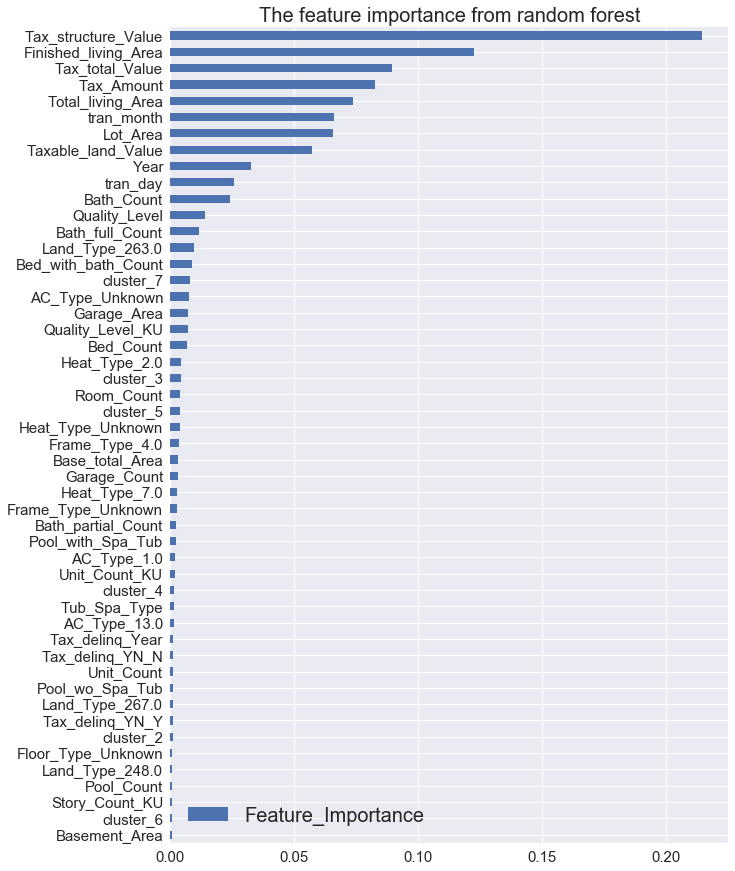

In [17]:
#Get the feature_importances_
fea_import = pd.DataFrame(rfr.feature_importances_, index = Xtr.columns, columns = ["Feature_Importance"]).sort_values(by = "Feature_Importance", ascending = True)
fea_import.tail(30)
#plot the feature importance
ax = fea_import.iloc[-50:, :].plot.barh(figsize = (10,15),fontsize = 15)
ax.set_title("The feature importance from random forest", fontsize = 20)
ax.legend(fontsize = 20)

In [27]:
#Fit Ridge regression using selected variables.
topvar = fea_import.index[-35:]
Xtrtop = Xtr[topvar]
Xtetop = Xte[topvar]

alphas = np.logspace(-6,4,11)
#alphas = np.arange(20, 500, 10)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(Xtrtop,ytr)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

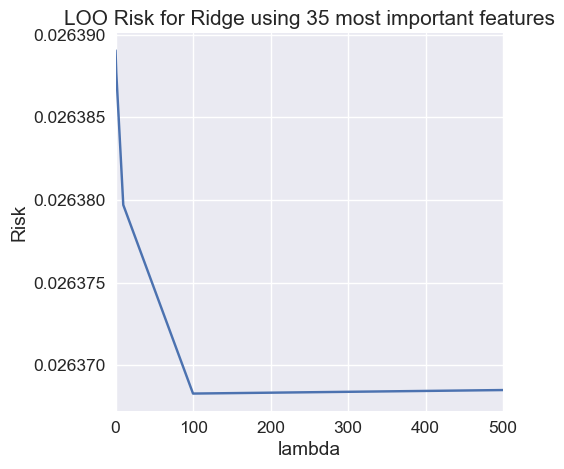

In [28]:
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge using 35 most important features')
plt.xlim([0,500])
#plt.ylim([0.006,0.010])
plt.show()

In [20]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(100.0, 0.026368294087319694)

In [21]:
rcv_m = Ridge(alpha = 100)
rcv_m.fit(Xtrtop, ytr)
yrcv = rcv_m.predict(Xtetop)
np.mean((yte - yrcv)**2)
#0.024006242727057713

0.024029955353443745

## Adaboost Regression

In [ ]:
## tune the adaboost parameters
t0 = time.time()
adr_model = Adr()
cross_validation = StratifiedKFold(n_splits = 5, shuffle = False, random_state = None)
parameter_grid = {"n_estimators":np.arange(10, 200, 10), "learning_rate": np.arange(0.2,5, 20)}

grid_search = GridSearchCV(adr_model, param_grid=parameter_grid, cv=cross_validation, n_jobs=4)
grid_search.fit(Xtr, ytr)
print grid_search.best_score_
print grid_search.best_params_
t1 = time.time()
print t1-t0

#-0.0206233166963
#{'n_estimators': 10, 'learning_rate': 0.20000000000000001}

In [22]:
adr = Adr(n_estimators = 10, learning_rate = 0.2)
adr.fit(X, y)
adrpred = adr.predict(Xte)
mseadr = np.mean((yte - adrpred)**2)
mseadr
#0.02429095645996899

0.024313896064324478

## Xgboost Regression

In [24]:
#use xgboost, note that xgboost only can handle DMatrix for Xtr
Xtrmat = Xtr.as_matrix()

In [ ]:
t0 = time.time()
xgb_model = xgb.XGBRegressor()
cross_validation = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
parameter_grid = {'max_depth': range(5,10), 'n_estimators': np.arange(10,100,10)}
xgbgrid = GridSearchCV(xgb_model, param_grid=parameter_grid, cv=cross_validation, n_jobs = 4) 
xgbgrid.fit(Xtrmat,ytr)
print xgbgrid.best_score_
print xgbgrid.best_params_
t1= time.time()
print t1-t0

##-0.0326175522931
#{'n_estimators': 60, 'max_depth': 5}
#6173.87779903

In [25]:
xgbm = xgb.XGBRegressor(max_depth = 5, n_estimators = 60)
xgbm.fit(Xtrmat, ytr)
xgbpred = xgbm.predict(Xte.as_matrix())
msexgb = np.mean((yte - xgbpred)**2)
msexgb
#0.02412646260009974

0.02412646260009974

# Conclusion

To summarize the results of different methods, we list the MSE calculated by each method with best parameters.

|            Methods           |          MSE         |
|:----------------------------:|:--------------------:|
|       Linear Regression      |7.08697486847e+21     |
|       Ridge Regression       |0.0239840000665       |
|       Lasso Regression       |0.0240007795803       |
|     Linear SVM Regression    |0.0240299833173       |
|   Random Forest Regression   |0.02416135186839929   |
| Ridge with selected features |0.024029955353443745  |
|      Adaboost Regression     |0.024313896064324478  |
|      Xgboost Regression      |0.02412646260009974   |

